In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
import joblib

In [2]:
# import clickhouse_connect
# DATABASE_NAME = 'binance_data_indicator' 
# # OHLC_1M = 'trx_1m_ohlc'  # Changed from btc to trx
# # # INDICATOR_1M = 'trx_1m_indicator'  # Changed from btc to trx

# TABLE1_NAME = 'trxusdt_1m_extended'  # Changed table's name
# TABLE2_NAME = 'trxusdt_1m_forward_ohlc'  # Changed table's name

# # CLICKHOUSE_HOST = 'localhost' # Get qua Docker
# CLICKHOUSE_HOST = '117.0.34.78'
# CLICKHOUSE_PORT = 8123
# CLICKHOUSE_USER = 'looker'
# CLICKHOUSE_PASSWORD = ''

# clickhouse_client = clickhouse_connect.get_client(host=CLICKHOUSE_HOST, port=CLICKHOUSE_PORT, username=CLICKHOUSE_USER, password=CLICKHOUSE_PASSWORD)

# # sql = f'''
# #     SELECT * FROM {DATABASE_NAME}.{INDICATOR_1M} FINAL
# #     WHERE OpenTime >= '2024-12-01 00:00:00'
# #     ORDER BY OpenTime DESC
# #     LIMIT 400000
# # '''

# sql = f'''
#     SELECT
#     a.OpenTime,
#     a.MinuteId AS MinuteId,
#     a.Close AS Close,
#     a.* EXCEPT(OpenTime, Close, MinuteId),
#     b.* EXCEPT(OpenTime, Close, MinuteId, StartCumulative)
#     FROM
#     (SELECT * FROM {DATABASE_NAME}.{TABLE1_NAME} FINAL) AS a
#     JOIN
#     (SELECT * FROM {DATABASE_NAME}.{TABLE2_NAME} FINAL) AS b
#     ON
#     a.OpenTime = b.OpenTime
#     WHERE
#     a.Valid = '1'
#     ORDER BY
#     a.OpenTime DESC
# '''
# # Đọc dữ liệu
# # df = clickhouse_client.query_df(sql)
# df = clickhouse_client.query_df(sql, settings={'max_result_rows': 500000})

# # Chuyển đổi OpenTime thành datetime
# df['OpenTime'] = pd.to_datetime(df['OpenTime'])

# df.set_index('OpenTime', inplace=True)

# # df[['Close','Low','High','min_low_5', 'min_low_10', 'max_high_5', 'max_high_10', 'min_low_30', 'max_high_30','close_vs_minlow5_pct', 'close_vs_minlow10_pct', 'close_vs_minlow30_pct']].head(30)
# # df[['OpenTime', 'macd_diff', 'sma_macd_diff_5','sma_macd_diff_10','sma_macd_diff_sub']].head(20)

In [3]:
import os

# Đường dẫn
data_path = r'F:/dataML/data/TRX/output/TRX_18_26555370_20200628_061900_223181.csv'

# Tên dataset
dataset_name = os.path.splitext(os.path.basename(data_path))[0]

today_str = datetime.today().strftime('%Y-%m-%d')

# Đọc dữ liệu
df = pd.read_csv(data_path)

# Chuyển đổi OpenTime thành datetime
df['OpenTime'] = pd.to_datetime(df['OpenTime'])

df.set_index('OpenTime', inplace=True)

# df[['Close','Low','High','min_low5', 'min_low10', 'max_high5', 'max_high10', 'min_low30', 'max_high30','close_vs_minlow5_pct', 'close_vs_minlow10_pct', 'close_vs_minlow30_pct']].head(30)


In [4]:
Y_TYPE = 'close_vs_maxhigh60_r8'

# Đếm số lượng bản ghi
count_rows = len(df)

# Đếm số lượng 0
count_zeros = (df[Y_TYPE] == 0).sum().sum()

# Đếm số lượng 1
count_ones = (df[Y_TYPE] == 1).sum().sum()

# In kết quả
print("Số lượng giá trị 0:", count_zeros)
print("Số lượng giá trị 1:", count_ones)
print("Số lượng bản ghi:", count_rows) 

Số lượng giá trị 0: 28028
Số lượng giá trị 1: 195153
Số lượng bản ghi: 223181


TRỰC QUAN HÓA % CỦA GIÁ "CLOSE" VỚI MIN LOW VÀ MIN HIGH

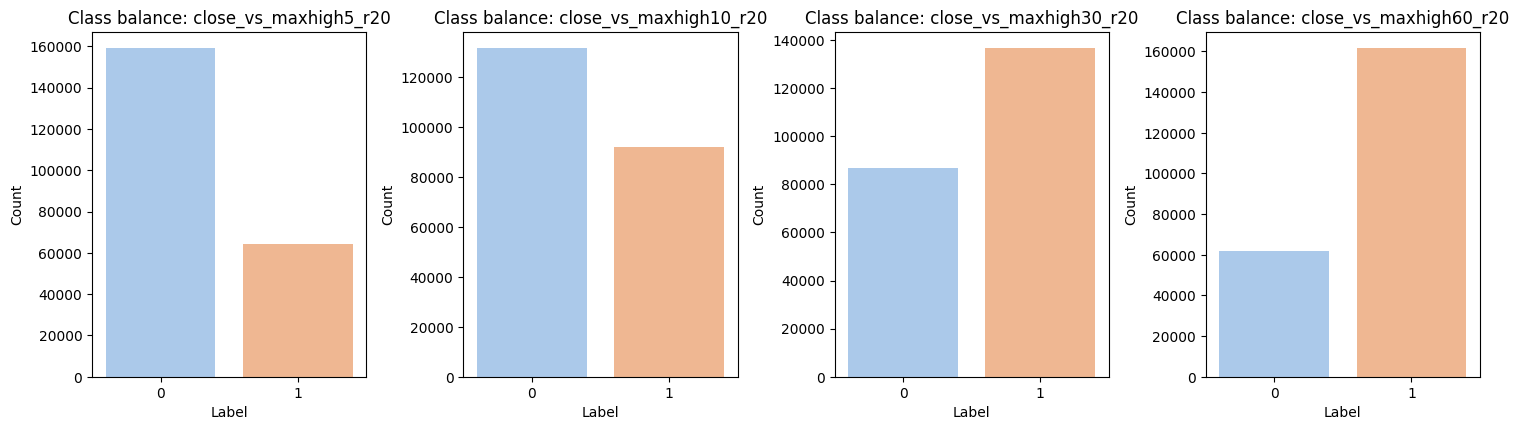

In [5]:
label_cols = [
    'close_vs_maxhigh5_r20',
    'close_vs_maxhigh10_r20',
    'close_vs_maxhigh30_r20',
    'close_vs_maxhigh60_r20'
    
]

# Điều chỉnh kích thước figure 
plt.figure(figsize=(15, 8))

for i, col in enumerate(label_cols):
    plt.subplot(2, 4, i + 1)  
    sns.countplot(data=df, x=col, hue=col, palette='pastel', legend=False)
    plt.title(f'Class balance: {col}')
    plt.xlabel('Label')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [6]:
df.isna().sum()

MinuteId                   0
Close                      0
StartCumulative            0
delta                      0
gain                       0
                          ..
close_vs_minlow60_r20      0
close_vs_maxhigh60_pct    60
close_vs_maxhigh60_r8      0
close_vs_maxhigh60_r10     0
close_vs_maxhigh60_r20     0
Length: 66, dtype: int64

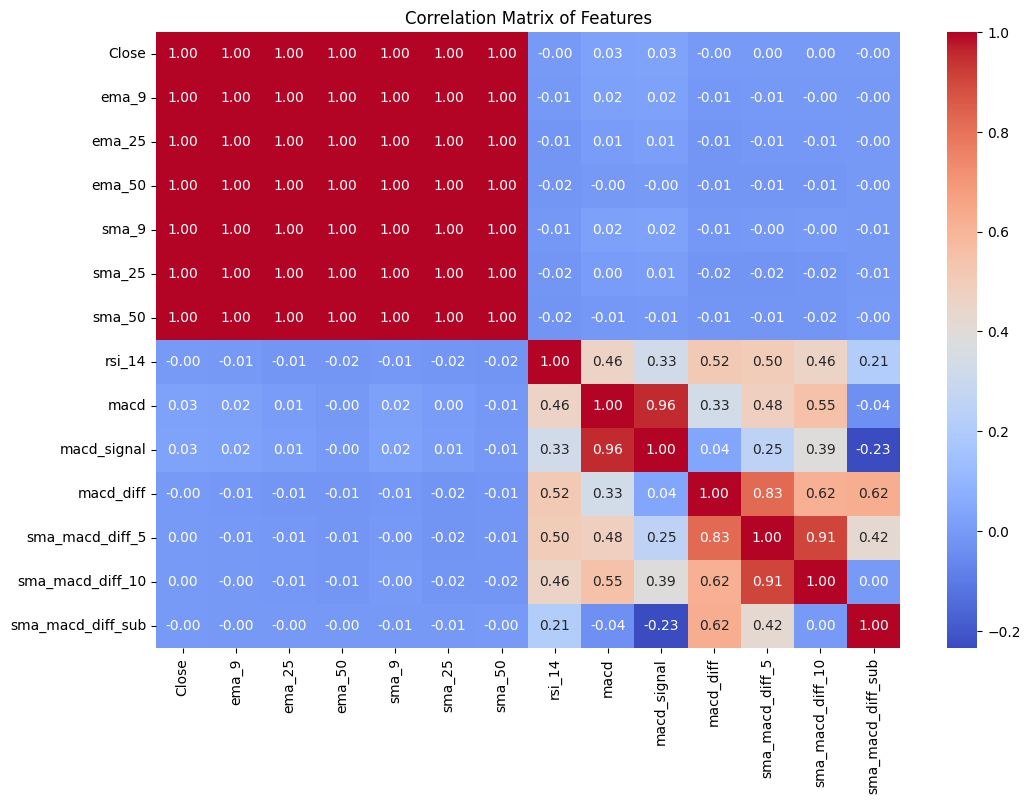

In [7]:
# 4. Kiểm tra tương quan
features_corr = [
    'Close', 
    'ema_9', 'ema_25', 'ema_50',
    'sma_9', 'sma_25', 'sma_50',
    'rsi_14',
    'macd', 'macd_signal', 'macd_diff',
    'sma_macd_diff_5', 'sma_macd_diff_10', 'sma_macd_diff_sub'
]


# print("Các cột hiện có trong df:")
# print(df.columns.tolist())

# missing_cols = [col for col in features_corr if col not in df.columns]
# print("Các cột bị thiếu:", missing_cols)


correlation_matrix = df[features_corr].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

CHIA DỮ LIỆU 70% TRAIN, 30% TEST

In [8]:
features = [
    # 'ema_9', 
    # 'ema_25',
    # 'ema_50',
    # 'sma_9', 
    # 'sma_25',
    # 'sma_50',
    'macd',
    # 'macd_signal',
    'macd_diff',
    'sma_macd_diff_5',
    'sma_macd_diff_10', 
    'sma_macd_diff_sub',
    'rsi_14',
]

X = df[features]
y = df[Y_TYPE]
print(Y_TYPE)

# Chia dữ liệu: 70% train, 30% test
# Bước 1: Chia 10% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)

# Bước 2: Chia 90% còn lại thành 77.8% train và 22.2% validation 
# (tương đương 70% và 20% của toàn bộ dữ liệu)
# X_train, X_test, y_train, y_test = train_test_split(
#     X_temp, y_temp, test_size=0.3, random_state=42, shuffle=False
# )

close_vs_maxhigh60_r8


In [9]:
import numpy as np
import pandas as pd

label_counts = pd.Series(y_train).value_counts()
label_percent = label_counts / label_counts.sum() * 100

print("Số lượng mỗi nhãn trong tập train:")
print(label_counts)

print("\nTỷ lệ phần trăm mỗi nhãn trong tập train:")
print(label_percent.round(2))

Số lượng mỗi nhãn trong tập train:
close_vs_maxhigh60_r8
1    136687
0     19539
Name: count, dtype: int64

Tỷ lệ phần trăm mỗi nhãn trong tập train:
close_vs_maxhigh60_r8
1    87.49
0    12.51
Name: count, dtype: float64


RANDOM FOREST PARAMS

In [ ]:
# rf_model = RandomForestClassifier(
#     n_estimators=250,         
#     max_depth=15,               
#     min_samples_split=10,       
#     min_samples_leaf=5,        
#     max_features='sqrt',       
#     bootstrap=True,            # Dùng bootstrap mẫu để huấn luyện từng cây
#     oob_score=True,            # Dùng mẫu ngoài (out-of-bag) để đánh giá độ chính xác
#     class_weight='balanced',   # Tự động cân bằng class nếu dữ liệu lệch (imbalanced)
#     random_state=42,           
#     n_jobs=-1,                 # Sử dụng tất cả các CPU
#     verbose=0,
# )
rf_model = RandomForestClassifier(
    n_estimators=1000,          # Tăng số lượng cây
    max_depth=10,            # Giữ nguyên để cây phát triển sâu
    min_samples_split=2,       # Cho phép chia tách nhỏ hơn
    min_samples_leaf=1,        # Cho phép lá có ít mẫu hơn
    max_features='sqrt',       # Giữ nguyên hoặc thử nghiệm sau
    bootstrap=True,
    oob_score=True,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,                 # Sử dụng tất cả các CPU
    verbose=0,
)

rf_model.fit(X_train, y_train)

# # Giả sử model của bạn là `model` và muốn lưu với tên theo `Y_TYPE`
# model_path = f'F:/dataML/models/RandomForest/{dataset_name}/{todaystr}/maxhigh/RF_{Y_TYPE}.joblib'
# os.makedirs(f"F:/dataML/models/RandomForest/{dataset_name}/{today_str}/maxhigh", exist_ok=True)
# joblib.dump(rf_model, model_path)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=1000,
                       n_jobs=12, oob_score=True, random_state=42)

In [11]:
print("Train accuracy:", rf_model.score(X_train, y_train))
print("Test accuracy:", rf_model.score(X_test, y_test))

Train accuracy: 0.5810172442487166
Test accuracy: 0.5712642819804347


ĐÁNH GIÁ ĐỘ CHÍNH XÁC

In [12]:
# Dự đoán và tính độ chính xác
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Độ chính xác của mô hình Random Forest: {accuracy_rf * 100:.2f}%")

# Lấy báo cáo phân loại dưới dạng dict
report = classification_report(y_test, y_pred_rf, output_dict=True)

# In báo cáo với phần trăm và dấu %
print("\nBáo cáo phân loại (%):")
print(f"{'Label':<12} {'Precision':>12} {'Recall':>12} {'F1-score':>12} {'Support':>10}")

def format_percent(value):
    return f"{value * 100:.2f}%"

for label, metrics in report.items():
    if isinstance(metrics, dict):
        print(f"{label:<12} {format_percent(metrics['precision']):>12} {format_percent(metrics['recall']):>12} {format_percent(metrics['f1-score']):>12} {int(metrics['support']):>10}")
    elif label == "accuracy":
        print(f"{label:<12} {'-':>12} {'-':>12} {format_percent(metrics):>12} {int(report['macro avg']['support']):>10}")

Độ chính xác của mô hình Random Forest: 57.13%

Báo cáo phân loại (%):
Label           Precision       Recall     F1-score    Support
0                  17.51%       64.19%       27.52%       8489
1                  91.52%       56.10%       69.56%      58466
accuracy                -            -       57.13%      66955
macro avg          54.52%       60.14%       48.54%      66955
weighted avg       82.13%       57.13%       64.23%      66955


KẾT QUẢ

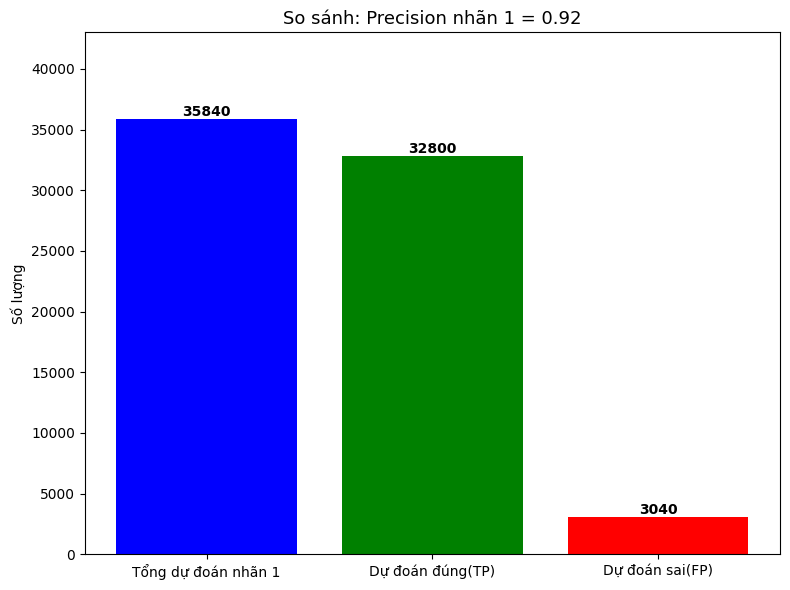

In [13]:
# Tính TP, FP cho nhãn 1
tp_1 = np.sum((y_test == 1) & (y_pred_rf == 1))  # True Positive
fp_1 = np.sum((y_test == 0) & (y_pred_rf == 1))  # False Positive
# tn_1 = np.sum((y_test == 0) & (y_pred_rf == 0))
# fn_1 = np.sum((y_test == 1) & (y_pred_rf == 0))

total_predicted_1 = tp_1 + fp_1  # Tổng số lần mô hình dự đoán là 1

# Precision cho nhãn 1 (ghi trong tiêu đề nếu muốn)
precision_1 = tp_1 / total_predicted_1 if total_predicted_1 > 0 else 0

# Dữ liệu biểu đồ
labels = ['Tổng dự đoán nhãn 1', 'Dự đoán đúng(TP)', 'Dự đoán sai(FP)']
values = [total_predicted_1, tp_1, fp_1]
colors = ['blue', 'green', 'red']

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=colors)

# Thêm số liệu trên đầu cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, f'{int(yval)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Tiêu đề biểu đồ
plt.title(f'So sánh: Precision nhãn 1 = {precision_1:.2f}', fontsize=13)
plt.ylabel('Số lượng')
plt.ylim(0, max(values) * 1.2)
plt.tight_layout()
plt.show()


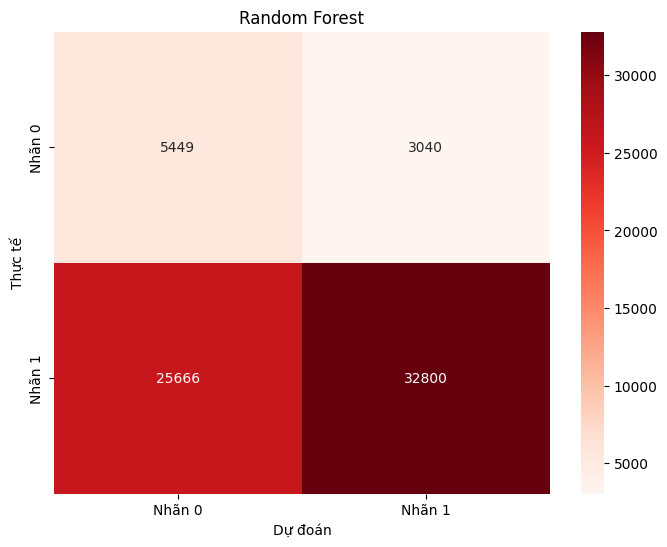

In [14]:
# Ma trận nhầm lẫn
cm_gb = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Nhãn 0', 'Nhãn 1'],
            yticklabels=['Nhãn 0', 'Nhãn 1'])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Random Forest')
plt.show()

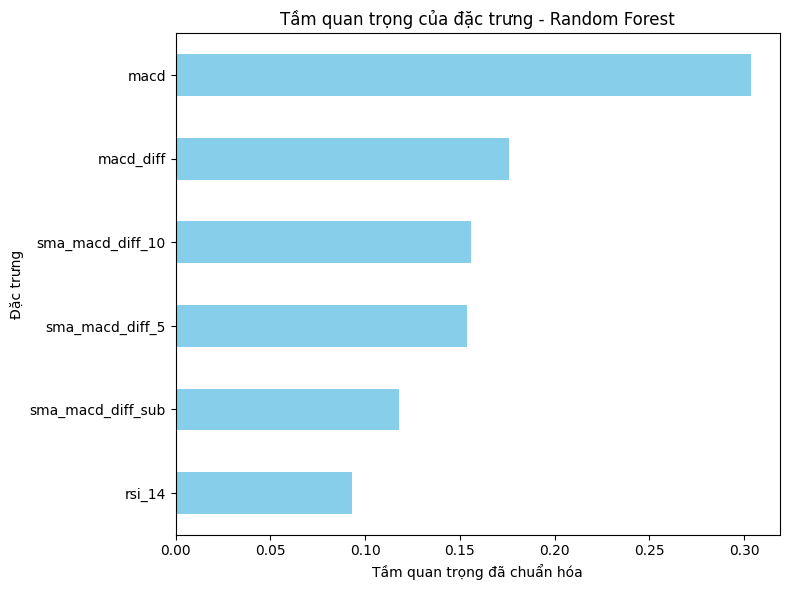

In [15]:
# Tính feature importance cho Random Forest model (rf_model)
rf_importance_raw = pd.Series(rf_model.feature_importances_, index=features)
rf_importance = rf_importance_raw / rf_importance_raw.sum()
rf_importance = rf_importance.sort_values()

# Vẽ biểu đồ riêng
plt.figure(figsize=(8, 6))
rf_importance.plot(kind='barh', color='skyblue')
plt.title('Tầm quan trọng của đặc trưng - Random Forest')
plt.xlabel('Tầm quan trọng đã chuẩn hóa')
plt.ylabel('Đặc trưng')
plt.tight_layout()
plt.show()


In [16]:
# Giả sử bạn đã huấn luyện rf_model xong trong ô trước đó
# Bước 1: Đọc file dữ liệu test mới
import pandas as pd
df_test = pd.read_csv('F:/dataML/data/TRX/TRX_2025-06-17_07-15-45.csv')

# Bước 2: Tách cột đầu ra (nếu có)
if Y_TYPE in df_test.columns:
    y_test_new = df_test[Y_TYPE]
    X_test_new = df_test.drop(columns=[Y_TYPE])
else:
    X_test_new = df_test
    y_test_new = None

# (Tùy chọn) Bảo đảm thứ tự và số cột giống X_train
X_test_new = X_test_new[rf_model.feature_names_in_]

# Bước 3: Dự đoán
y_pred = rf_model.predict(X_test_new)

# Bước 4: Đánh giá nếu có nhãn thật
if y_test_new is not None:
    from sklearn.metrics import classification_report
    print(classification_report(y_test_new, y_pred))
else:
    print("✅ Dự đoán hoàn tất, hiển thị kết quả:")
    print(y_pred[:10])

              precision    recall  f1-score   support

           0       0.78      0.05      0.09      1576
           1       0.67      0.99      0.80      3119

    accuracy                           0.68      4695
   macro avg       0.73      0.52      0.44      4695
weighted avg       0.71      0.68      0.56      4695

